Importing required libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Function to locate flag using sobel

In [2]:
def locate_flag_region(image):
    
    # Convert to grayscale
    grayscale_image = np.array(image.convert("L"))
    
    # Threshold to create a binary image
    threshold = 128
    binary_image = np.where(grayscale_image > threshold, 255, 0).astype(np.uint8)
    
    # Detect vertical and horizontal edges by difference
    vertical_edges = np.abs(np.diff(binary_image, axis=0))
    horizontal_edges = np.abs(np.diff(binary_image, axis=1))
    
    # Sum the edges to find potential flag regions
    edge_map = np.zeros_like(binary_image)
    edge_map[:-1, :] += vertical_edges
    edge_map[:, :-1] += horizontal_edges
    
    # Identify the rectangle with the most edges (a rough heuristic for a flag)
    y_sum = np.sum(edge_map, axis=1)  # Sum along rows
    x_sum = np.sum(edge_map, axis=0)  # Sum along columns
    
    # Find bounding box
    y_nonzero = np.where(y_sum > y_sum.mean())[0]
    x_nonzero = np.where(x_sum > x_sum.mean())[0]
    
    if len(y_nonzero) == 0 or len(x_nonzero) == 0:
        return None, None  # No flag region found
    
    y_min, y_max = y_nonzero[0], y_nonzero[-1]
    x_min, x_max = x_nonzero[0], x_nonzero[-1]
    
    # Crop the flag region
    flag_region = grayscale_image[y_min:y_max, x_min:x_max]
    return Image.fromarray(flag_region), (x_min, x_max, y_min, y_max)

Function to identify flag

In [3]:
def identify_flag(image_path):
    # Step 1: Load the image
    image = Image.open(image_path)
    
    # Step 2: Locate the flag region
    flag_region, region_coords = locate_flag_region(image)
    if flag_region is None:
        return "No flag region detected", None
    
    # Step 3: Resize the flag region to a standard size
    resized_flag = flag_region.resize((100, 60))
    
    # Step 4: Convert the flag to grayscale
    grayscale_flag = np.array(resized_flag)
    
    # Step 5: Split into top and bottom halves
    height = grayscale_flag.shape[0]
    top_half = grayscale_flag[:height // 2, :]
    bottom_half = grayscale_flag[height // 2:, :]
    
    # Step 6: Calculate mean intensity of each half
    top_mean = np.mean(top_half)
    bottom_mean = np.mean(bottom_half)
    
    # Step 7: Determine flag based on intensity comparison
    if top_mean < bottom_mean:  # Top is darker (red), bottom is lighter (white)
        return "Indonesia", region_coords
    elif top_mean > bottom_mean:  # Top is lighter (white), bottom is darker (red)
        return "Poland", region_coords
    else:
        return "Unknown flag", region_coords

Function to show image alongwith coordinate and also mapping flag

In [4]:
def show_images_in_grid(image_paths):
    num_images = len(image_paths)
    
    # Create a 5x2 grid for displaying images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i, image_path in enumerate(image_paths):
        result, region_coords = identify_flag(image_path)
        
        # Display the image with detected region
        image = Image.open(image_path)
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{result}")
        
        if region_coords:
            x_min, x_max, y_min, y_max = region_coords
            axes[i, 0].add_patch(
                plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                              linewidth=2, edgecolor='red', facecolor='none')
            )
        
        # Show the cropped region (flag region) on the right side
        flag_region, _ = locate_flag_region(image)
        if flag_region is not None:
            axes[i, 1].imshow(flag_region, cmap='gray')
            axes[i, 1].axis('off')
            axes[i, 1].set_title("Flag Region")
    
    plt.tight_layout()
    plt.show()

Run Code

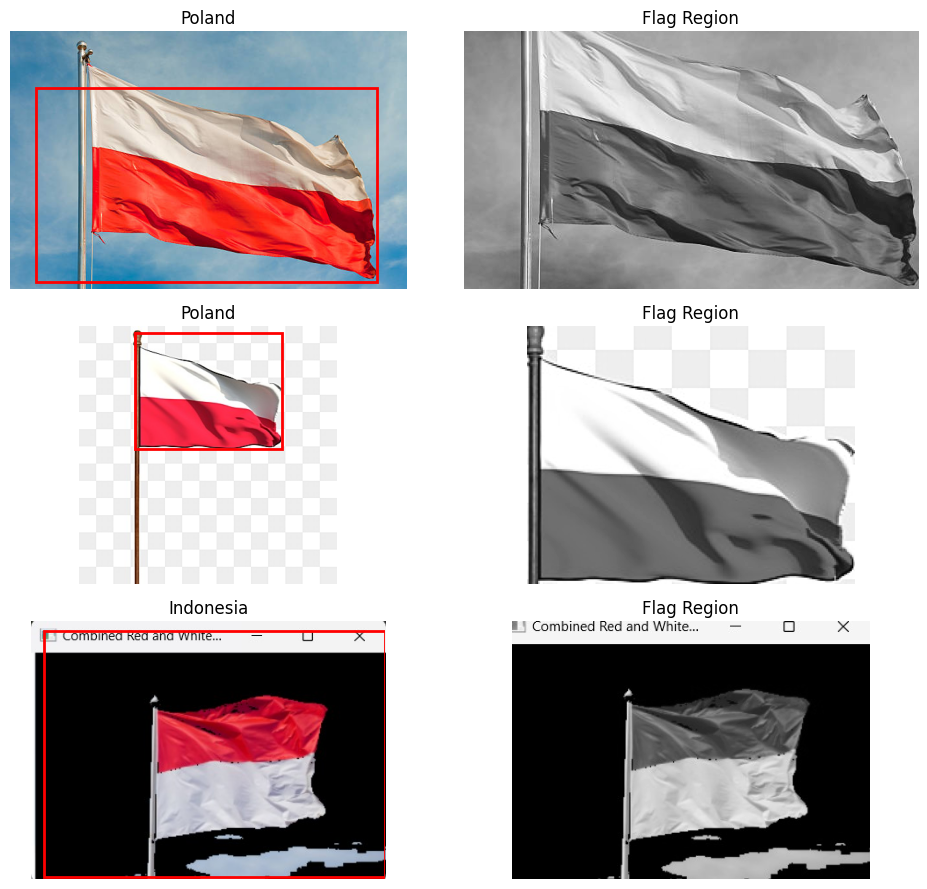

In [5]:
image_paths = [f"poland{i}.jpg" for i in range(1, 4)]  # Image paths for poland1.jpg, poland2.jpg, ..., poland5.jpg
show_images_in_grid(image_paths)